# Setup

In [69]:
from google.colab import drive
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

In [70]:
# Mount Google Drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/ManVSMachineLearning'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# Load CSV
train_csv = pd.read_csv(os.path.join(base_dir, 'train.csv'))
test_csv = pd.read_csv(os.path.join(base_dir, 'test.csv'))
train_csv = train_csv.dropna(subset=['label'])
train_csv['label'] = train_csv['label'].map({2: 0, 1: 1})

# Dataset Class

In [72]:
# Dataset class
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      img_name = self.df.iloc[idx]['image']
      img_path = os.path.join(self.img_dir, img_name)
      image = Image.open(img_path).convert('RGB')

      if self.transform:
          image = self.transform(image)

      # Pastikan label selalu ada saat training
      if 'label' in self.df.columns:
          label_val = self.df.iloc[idx]['label']
          if pd.isna(label_val):
              # Kalau label kosong, return dummy label -1
              label = torch.tensor(-1, dtype=torch.long)
          else:
              label = torch.tensor(int(label_val), dtype=torch.long)
          return image, label
      else:
          return image, torch.tensor(-1, dtype=torch.long)


# Transform

In [73]:
# Transformasi dengan augmentasi data
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Split Data & Dataloader

In [74]:
# Split data
train_df, val_df = train_test_split(train_csv, test_size=0.1, random_state=42)
train_df = train_df.dropna(subset=['label'])
val_df = val_df.dropna(subset=['label'])
train_dataset = ImageDataset(train_df, os.path.join(base_dir, 'train'), transform=transform_train)
val_dataset = ImageDataset(val_df, os.path.join(base_dir, 'train'), transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model

In [75]:
# Setup model dan transfer learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('efficientformerv2_s0', pretrained=True, num_classes=2)

In [76]:
# Freeze semua layer kecuali classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

model.to(device)

EfficientFormerV2(
  (stem): Stem4(
    (conv1): ConvNormAct(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): GELU()
      )
    )
    (conv2): ConvNormAct(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): GELU()
      )
    )
  )
  (stages): Sequential(
    (0): EfficientFormerV2Stage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): EfficientFormerV2Block(
          (mlp): ConvMlpWithNorm(
            (fc1): ConvNormAct(
              (conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
              (bn): BatchNormAct2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
     

In [77]:
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.head.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

# Training Model

In [78]:
# Training
best_val_acc = 0.0
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Loss: 0.6910
Epoch 2, Loss: 0.6727
Epoch 3, Loss: 0.6604
Epoch 4, Loss: 0.6540
Epoch 5, Loss: 0.6488
Epoch 6, Loss: 0.6451
Epoch 7, Loss: 0.6428
Epoch 8, Loss: 0.6413
Epoch 9, Loss: 0.6399
Epoch 10, Loss: 0.6399


# Evaluasi Validasi


In [79]:
# validasi setelah selesai training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Validation Accuracy: 75.00%


# Prediksi Data Test

Saving p13.jpg to p13 (2).jpg


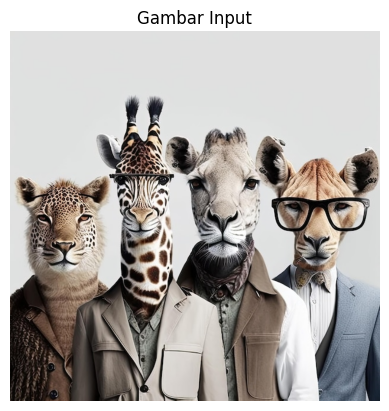

Pengujian pada Arsitektur EfficientFormerV2
File: p13 (2).jpg
Prediksi: AI
Akurasi Keyakinan: 52.43%


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import torch
from torchvision import transforms

# Upload gambar
uploaded = files.upload()

# Transformasi sama seperti data validasi
transform_single = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Label sesuai mapping sebelumnya: 0 = Human, 1 = AI
class_names = ['Human', 'AI']

# Model ke evaluasi mode
model.eval()

for fn in uploaded.keys():
    # Load dan tampilkan gambar
    img_path = fn
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    plt.title("Gambar Input")
    plt.show()

    # Preprocessing
    input_tensor = transform_single(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = torch.softmax(output, dim=1)[0][predicted_class].item() * 100

    print("Pengujian pada Arsitektur EfficientFormerV2")
    print(f"File: {fn}")
    print(f"Prediksi: {class_names[predicted_class]}")
    print(f"Akurasi Keyakinan: {confidence:.2f}%")


Classification Report:
              precision    recall  f1-score   support

       Human       0.00      0.00      0.00         0
          AI       1.00      0.75      0.86        44

    accuracy                           0.75        44
   macro avg       0.50      0.38      0.43        44
weighted avg       1.00      0.75      0.86        44



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


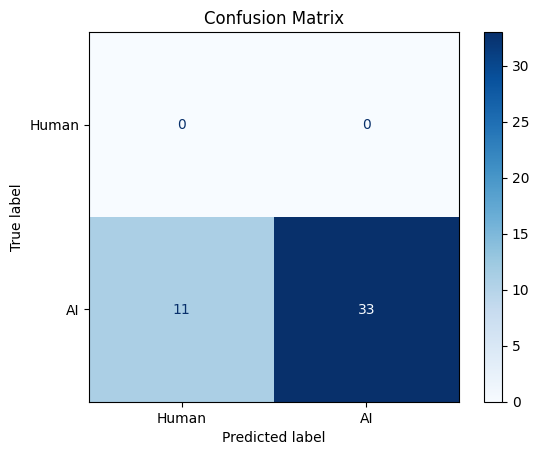

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluasi model pada data validasi
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Human", "AI"]))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [82]:
output_df = test_csv.copy()
output_df['label'] = [1 if p == 1 else 2 for p in predictions]

# Simpan hasil prediksi
output_df.to_csv(os.path.join(base_dir, 'submission.csv'), index=False)
print("Prediksi disimpan di: submission.csv")

Prediksi disimpan di: submission.csv
